# Análisis de las vecindades de los píxeles tras la transformación LBP

En primer lugar se realiza la carga de la imagen sobre la que se va a realizar el proceso y se indican los parámetros seleccionados.

In [1]:
from preprocess.preprocess import *
import PARAMETERS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from confusion_matrix_pretty_print import print_confusion_matrix
from main import init_clf_and_fit
import zipfile

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu2'
pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu2,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height=PARAMETERS.HEIGHT,
    width=PARAMETERS.WIDTH,
    balance=PARAMETERS.BALANCE
)

In [3]:
parent_path = '..'
path = list(Path(f"{parent_path}/dataset/training/images").glob('*.tif'))[0]
lbp_path = list(Path(f"{path.parent.parent}/preprocessed/{PARAMETERS.INTERPOLATION_ALGORITHM}/lbp/{PARAMETERS.LBP_METHOD}").glob(f"{str(path).split('/')[-1].split('_')[0]}_training_1.0*"))[0]
mask_path = list(Path(f"{path.parent.parent}/mask").glob(f"{str(path).split('/')[-1].split('_')[0]}*"))[0]

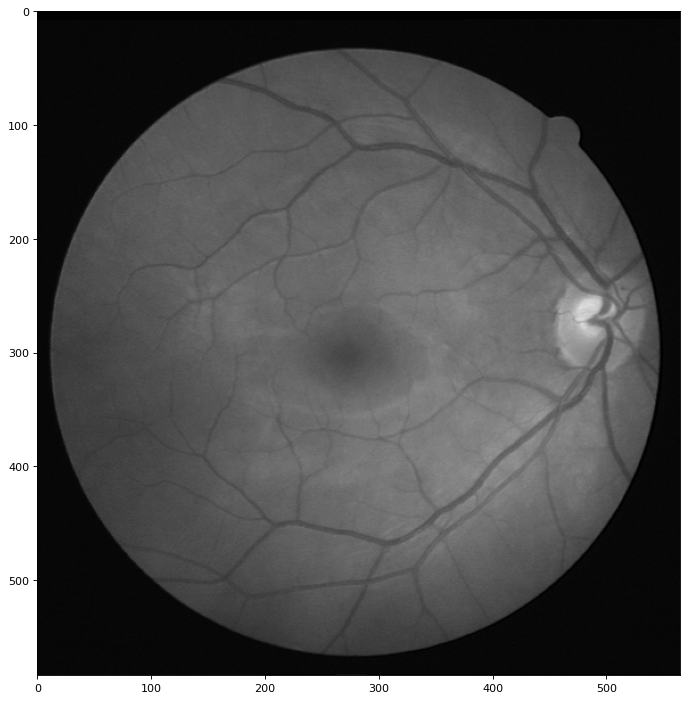

In [4]:
def plot_img(img, v_min=0, v_max=255):
    plt.figure(figsize=(15, 11), dpi=80)
    plt.imshow(img, cmap='gray', vmin=v_min, vmax=v_max)
    plt.show()
    

img = preprocess.read_img(path)
plot_img(img)

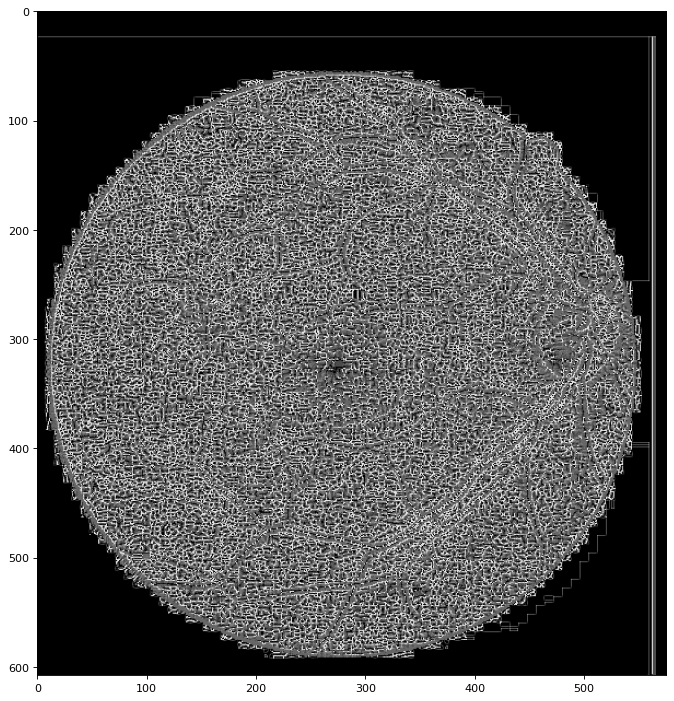

In [5]:
_, mask = preprocess.filter_by_mask(img.copy(), mask_path)
with open(lbp_path, 'rb') as f:
    img_lbp = pickle.load(f)
plot_img(img_lbp, v_max={
                'default': 256,
                'riu': 36,
                'riu2': 10
            }[PARAMETERS.LBP_METHOD])

In [6]:
"""
kernel_list = [
    np.array(
        [[1, 0, 1],
         [0, 0, 0],
         [0, 1, 0]]
    ),
    np.array(
        [[0, 1, 0],
         [0, 0, 0],
         [1, 0, 1]]
    ),
    np.array(
        [[0, 0, 1],
         [1, 0, 0],
         [0, 0, 1]]
    ),
    np.array(
        [[1, 0, 0],
         [0, 0, 1],
         [1, 0, 0]]
    ),
    np.array(
        [[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]]
    ),
    np.array(
        [[0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]]
    ),
    np.array(
        [[0, 0, 0],
         [0, 0, 0],
         [1, 1, 1]]
    ),
    np.array(
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]]
    )
]
"""
kernel_positions = set(itertools.permutations([1, 1, 1, 0, 0, 0, 0, 0]))

kernel_list = []
for kernel_position in kernel_positions:
    kernel_position = np.array(list(kernel_position[:4]) + [0] + list(kernel_position[4:]))
    kernel_list.append(kernel_position.reshape(3, 3))

In [7]:
def neighborhood_extractor(img_lbp, x, y, kernel):
    r = kernel.shape[0]//2
    matrix = img_lbp[x - r:x + r + 1, y - r:y + r + 1]
    if matrix.shape[0]*matrix.shape[1] != kernel.shape[0]*kernel.shape[1]:
        '''
        When there are no neighboring pixels for the given radius,
        a zero value is given to some virtual pixels outside the edges.
        '''
        img_resized = np.zeros(np.array(img_lbp.shape) + 2*(r + 1))
        img_resized[r+1:-r-1, r+1:-r-1] = img_lbp
        x += r + 1
        y += r + 1
        matrix = img_resized[x - r:x + r + 1, y - r:y + r + 1].astype(int)
    neighborhood = (matrix * kernel)[kernel.astype(bool)]
    # Pixels are sorted to reduce the number of possible values
    neighborhood.sort()
    return ''.join(neighborhood.astype(str))

# Example
print(neighborhood_extractor(img_lbp, 200, 476, kernel_list[0]))

037


In [8]:
def neighborhood_features(img_lbp, kernel):
    height, width = img_lbp.shape
    img_feat = np.zeros((height, width), np.uint16)
    for i in range(0, height):
        img_feat[i, :] = [neighborhood_extractor(img_lbp, i, j, kernel) for j in range(0, width)]
    return img_feat

shape_1 = len(preprocess.remove_mask_data(np.zeros(img_lbp.shape).ravel().reshape(-1, 1), mask, remove_borders=True)[0])
feat_matrix = np.zeros((shape_1, len(kernel_list)), dtype=np.uint16)
for i, kernel in enumerate(kernel_list):
    feat_matrix[:, i] = preprocess.remove_mask_data(neighborhood_features(img_lbp, kernel).ravel().reshape(-1, 1), mask, remove_borders=True)[0].ravel()

In [9]:
label_path = list(Path(f"{path.parent.parent}/1st_manual").glob(f"{str(path).split('/')[-1].split('_')[0]}*"))[0]
label = preprocess.get_label(label_path).reshape(-1, 1)
label, _ = preprocess.remove_mask_data(label, mask)

In [10]:
def features_maping(length=3):
    numbers_list = [list(map(str,  range(10)))]*length
    possible_values = sorted({int(''.join(sorted(combination))) for combination in itertools.product(*numbers_list)})
    v = 0
    features_map = {}
    for k in possible_values:
        features_map[k] = v
        v += 1
    return features_map

features_map = features_maping(length=kernel.sum())
print(features_map)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 22: 19, 23: 20, 24: 21, 25: 22, 26: 23, 27: 24, 28: 25, 29: 26, 33: 27, 34: 28, 35: 29, 36: 30, 37: 31, 38: 32, 39: 33, 44: 34, 45: 35, 46: 36, 47: 37, 48: 38, 49: 39, 55: 40, 56: 41, 57: 42, 58: 43, 59: 44, 66: 45, 67: 46, 68: 47, 69: 48, 77: 49, 78: 50, 79: 51, 88: 52, 89: 53, 99: 54, 111: 55, 112: 56, 113: 57, 114: 58, 115: 59, 116: 60, 117: 61, 118: 62, 119: 63, 122: 64, 123: 65, 124: 66, 125: 67, 126: 68, 127: 69, 128: 70, 129: 71, 133: 72, 134: 73, 135: 74, 136: 75, 137: 76, 138: 77, 139: 78, 144: 79, 145: 80, 146: 81, 147: 82, 148: 83, 149: 84, 155: 85, 156: 86, 157: 87, 158: 88, 159: 89, 166: 90, 167: 91, 168: 92, 169: 93, 177: 94, 178: 95, 179: 96, 188: 97, 189: 98, 199: 99, 222: 100, 223: 101, 224: 102, 225: 103, 226: 104, 227: 105, 228: 106, 229: 107, 233: 108, 234: 109, 235: 110, 236: 111, 237: 112, 238: 113, 239: 114, 244: 115, 245: 116, 246:

In [11]:
feat_matrix = np.vectorize(features_map.get)(feat_matrix)
df = pd.DataFrame(feat_matrix).applymap(np.uint16)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,28,12,12,13,73,28,34,73,13,143,...,79,12,73,143,57,143,13,79,73,12
1,72,80,57,57,143,74,73,137,58,144,...,73,59,80,143,73,137,79,143,73,73
2,73,79,79,73,143,73,72,143,73,137,...,137,79,143,137,164,137,73,137,143,79
3,164,164,164,164,164,164,164,164,164,164,...,143,164,164,143,164,164,143,164,143,164
4,164,143,164,164,164,143,164,164,164,143,...,164,143,143,164,164,164,164,164,164,164


In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    feat_matrix, label, test_size=0.33, random_state=42, stratify=label)

clf = init_clf_and_fit(x_train, y_train)
y_predicted = clf.predict(x_test)

acc = accuracy_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)
print('Accuracy score: ' + str(acc) + '\n')
print('F1 score: ' + str(f1) + '\n')
print('Confusion matrix:\n')
print_confusion_matrix(y_test.ravel(), y_predicted)

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy score: 0.7021276595744681

F1 score: 0.33400894187779434

Confusion matrix:

     t/p      0     1 
        0 47065 18793 
        1  3551  5603 


In [13]:
def pixel_neighborhood_main(kernel_list):
    PARAMETERS.LBP_METHOD = 'riu2'
    preprocess = Preprocess(
        lbp_radius=1,
        lbp_method=PARAMETERS.LBP_METHOD,
        height=PARAMETERS.HEIGHT,
        width=PARAMETERS.WIDTH,
        balance=PARAMETERS.BALANCE
    )
    parent_path = '..'
    paths = sorted(Path(f"{parent_path}/dataset/training/images").glob('*.tif'))
    pixel_neighborhood_path = f"{parent_path}/DB/extra_features/pixel_neighborhood"
    df_train = None
    df_test = None
    
    def pixel_neighborhood_single_image(path):
        lbp_path = list(Path(f"{path.parent.parent}/preprocessed/{PARAMETERS.INTERPOLATION_ALGORITHM}/lbp/{PARAMETERS.LBP_METHOD}").glob(f"{str(path).split('/')[-1].split('_')[0]}_training_1.0*"))[0]
        mask_path = list(Path(f"{path.parent.parent}/mask").glob(f"{str(path).split('/')[-1].split('_')[0]}*"))[0]
        img = preprocess.read_img(path)
        _, mask = preprocess.filter_by_mask(img.copy(), mask_path)
        with open(lbp_path, 'rb') as f:
            img_lbp = pickle.load(f)
        shape_1 = len(preprocess.remove_mask_data(np.zeros(img_lbp.shape).ravel().reshape(-1, 1), mask, remove_borders=True)[0])
        feat_matrix = np.zeros((shape_1, len(kernel_list)), dtype=np.uint16)
        for i, kernel in enumerate(kernel_list):
            filename = f"{str(path).split('/')[-1].split('_')[0]}_{''.join(list(kernel.ravel().astype('str')))}"
            file_path = f"{pixel_neighborhood_path}/{filename}.pkl"
            if os.path.isfile(file_path):
                with open(file_path, 'rb') as f:
                    kernel_feat = pickle.load(f)
            else:
                print('entra')
                kernel_feat = preprocess.remove_mask_data(neighborhood_features(img_lbp, kernel).ravel().reshape(-1, 1), mask, remove_borders=True)[0].ravel()
                with open(file_path, 'wb') as f:
                    pickle.dump(kernel_feat, f)
            feat_matrix[:, i] = kernel_feat
        features_map = features_maping(length=kernel.sum())
        feat_matrix = np.vectorize(features_map.get)(feat_matrix)
        return pd.DataFrame(feat_matrix).applymap(np.uint16)
    
    for path in paths[:14]:
        if df_train is None:
            df_train = pixel_neighborhood_single_image(path)
        else:
            df_train = pd.concat([df_train, pixel_neighborhood_single_image(path)], axis=0)
    
    for path in paths[14:]:
        if df_test is None:
            df_test = pixel_neighborhood_single_image(path)
        else:
            df_test = pd.concat([df_test, pixel_neighborhood_single_image(path)], axis=0)
    return df_train, df_test

df_train_pn, df_test_pn = pixel_neighborhood_main(kernel_list)

In [14]:
import PARAMETERS
from main import *

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072865 seconds.
You can set `force_col_wise=true` to remove the overhead.


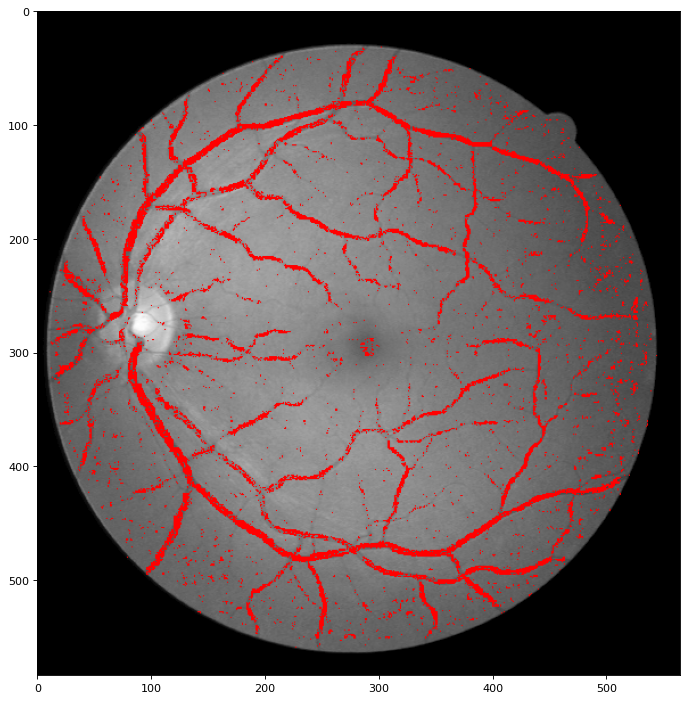

Accuracy score: 0.9066512463794492

F1 score: 0.5710132904370231

Confusion matrix:

     t/p      0     1 
        0 1150839 36706 
        1 90501 84661 
Sensivity: 0.4833297176328199
Specificity: 0.969090855504423


(0.907, 0.571, 1150839, 36706, 90501, 84661)

In [15]:
main(lgb=True, plot_once=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.527224 seconds.
You can set `force_col_wise=true` to remove the overhead.


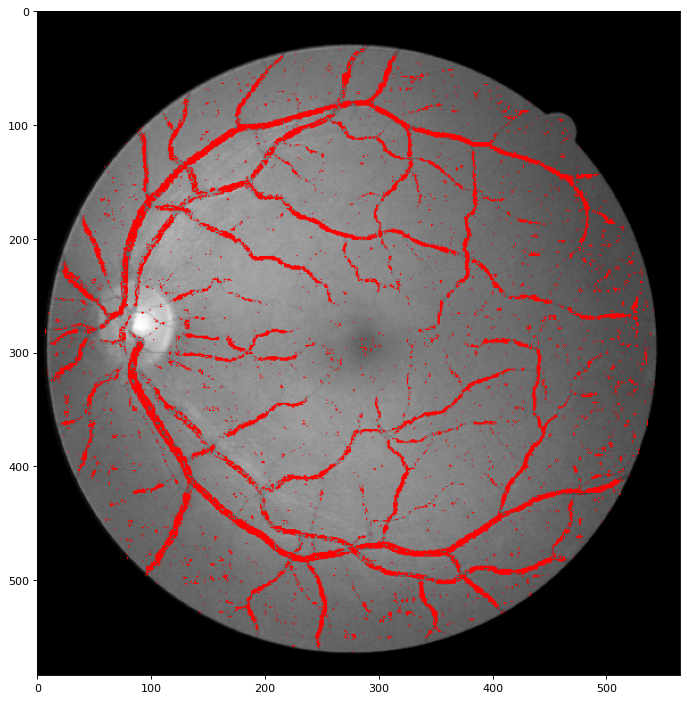

Accuracy score: 0.9132454738986444

F1 score: 0.6065896180736964

Confusion matrix:

     t/p      0     1 
        0 1153345 34200 
        1 84021 91141 
Sensivity: 0.5203240428860141
Specificity: 0.9712010913270654


(0.913, 0.607, 1153345, 34200, 84021, 91141)

In [16]:
main(lgb=True, plot_once=True, all_lbp=False, extra_features={'train': df_train_pn, 'test': df_test_pn})

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.704736 seconds.
You can set `force_col_wise=true` to remove the overhead.


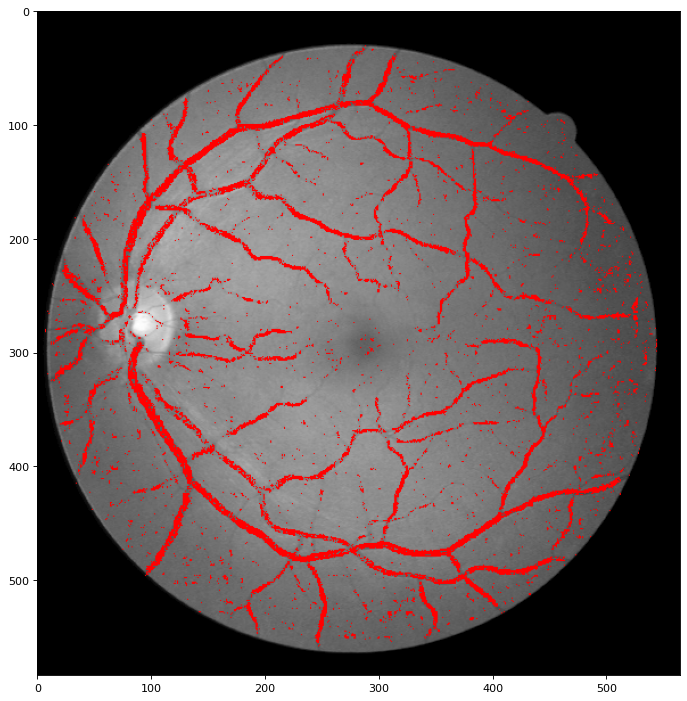

Accuracy score: 0.9134494796019981

F1 score: 0.6083332503129868

Confusion matrix:

     t/p      0     1 
        0 1153170 34375 
        1 83568 91594 
Sensivity: 0.5229102202532513
Specificity: 0.9710537284902888


(0.913, 0.608, 1153170, 34375, 83568, 91594)

In [17]:
main(lgb=True, plot_once=True, all_lbp=True, extra_features={'train': df_train_pn, 'test': df_test_pn})